# Libraries installation

In [ ]:
!pip install autogluon

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
pip install lightgbm --config-settings=cmake.define.USE_GPU=ON

Note: you may need to restart the kernel to use updated packages.


# Data preprocessing

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
dfx = pd.read_csv('x_train_final.csv')
dfy=pd.read_csv('y_train_final_j5KGWWK.csv')
df_test=pd.read_csv('x_test_final.csv')

df_test=df_test.drop('Unnamed: 0', axis=1)
dfx=dfx.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1)
dfy=dfy.drop('Unnamed: 0', axis=1)

def preprocess1(df):
    # Convertir la colonne 'date' en format datetime si ce n'est pas déjà le cas
    df['date'] = pd.to_datetime(df['date'])

    # Extraire le mois et le jour dans de nouvelles colonnes
    df['mois'] = df['date'].dt.month
    df['jour'] = df['date'].dt.day
    df=df.drop('date', axis=1)
    # Retourner le DataFrame modifié
    return df

dfx=preprocess1(dfx)
df_test=preprocess1(df_test)
dfy['p0q0'] = dfy['p0q0'].astype(int)


dfy.describe()
def filter_dataframe(dfx, dfy):
    # Appliquer les conditions sur les colonnes de dfx
    filtered_dfx = dfx[
        (dfx['p2q0'] >= -32) & (dfx['p2q0'] <= 6) &
        (dfx['p3q0'] >= -31) & (dfx['p3q0'] <= 6) &
        (dfx['p4q0'] >= -46) & (dfx['p4q0'] <= 9) &
        (dfx['p0q2'] >= -46) & (dfx['p0q2'] <= 11) &
        (dfx['p0q3'] >= -66) & (dfx['p0q3'] <= 6) &
        (dfx['p0q4'] >= -57) & (dfx['p0q4'] <= 9)
    ]
    filtered_dfy = dfy.loc[filtered_dfx.index]
    filtered_dfy = filtered_dfy[(filtered_dfy['p0q0'] >= -66) & (filtered_dfy['p0q0'] <= 15)]
    filtered_dfx = filtered_dfx.loc[filtered_dfy.index]

    return filtered_dfx, filtered_dfy
# Appliquer la fonction de filtrage
dfx, dfy = filter_dataframe(dfx, dfy)



dfx= pd.concat([dfx, dfy['p0q0']], axis=1)


In [ ]:
from sklearn.preprocessing import StandardScaler

def normalize_and_center(train_df, test_df, exclude_col=None):
    """Normalise et centre toutes les variables numériques"""
    # Liste des colonnes numériques à normaliser
    numeric_cols = train_df.select_dtypes(include=np.number).columns.tolist()

    # Exclusion de la colonne cible si elle est présente
    if exclude_col and exclude_col in numeric_cols:
        numeric_cols.remove(exclude_col)

    # Création du scaler
    scaler = StandardScaler()

    # Application sur le train
    train_df[numeric_cols] = scaler.fit_transform(train_df[numeric_cols])

    # Application sur le test avec le même scaler
    test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])

    return train_df, test_df

# Suppression de la colonne cible du dataframe de features
dfx = dfx.drop('p0q0', axis=1)

# Application de la normalisation
dfx, df_test = normalize_and_center(dfx, df_test)

# Réajout de la colonne cible au dataframe d'entraînement
dfx = pd.concat([dfx, dfy['p0q0']], axis=1)

dfx=dfx.drop('gare', axis=1)

In [ ]:


# Gares dans df_test mais pas dans dfx
valeurs_dans_test_pas_dans_dfx = set(dfx["gare"]) - set(df_test["gare"])
print("Valeurs présentes dans df_test mais pas dans dfx :", valeurs_dans_test_pas_dans_dfx)

# Gares dans dfx mais pas dans df_test
valeurs_dans_dfx_pas_dans_test = set(df_test["gare"]) - set(dfx["gare"])
print("Valeurs présentes dans dfx mais pas dans df_test :", valeurs_dans_dfx_pas_dans_test)

#Gares dans les 2
valeurs_dans_les_2 = set(df_test["gare"]) & set(dfx["gare"])
print("Gares dans les 2 :", valeurs_dans_les_2)




KeyError: 'gare'

In [ ]:
# prompt: Fais un code qui supprime les gares "OUA", "TXR",  "BKS" de dfx

# Supprimer les gares spécifiées de dfx
gares_a_supprimer = ["OUA", "TXR", "BKS"]
dfx = dfx[~dfx['gare'].isin(gares_a_supprimer)]


# Model training

In [ ]:
import ray
ray.shutdown()
ray.init(num_cpus=107)

2025-02-15 15:01:18,903	INFO worker.py:1810 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.11.11
Ray version:,2.39.0
Dashboard:,http://127.0.0.1:8265


In [ ]:
train_df = dfx

# Modèle 1 : MAE=0.65

In [ ]:
import logging
from autogluon.tabular import TabularPredictor

# Configuration du logging pour suivre les étapes
logging.basicConfig(level=logging.INFO)

# Configuration du prédicteur
predictor = TabularPredictor(
    label='p0q0',  # Nom de la colonne cible
    eval_metric='f1_weighted',  # Optimisation pour un problème déséquilibré multiclasses
    problem_type='multiclass'  # Spécifiez le type de problème
)

# Entraînement avec plusieurs optimisations
predictor.fit(
    train_data=train_df,  # Données d'entraînement
    time_limit=3600 * 3,  # Limite de 5 heures pour l'entraînement
    presets='best_quality',  # Priorise la qualité des modèles au lieu de la vitesse
    num_stack_levels=1,  # Active un niveau d'empilement pour combiner plusieurs modèles
    num_bag_folds=5,  # Cross-validation avec 5 folds pour plus de robustesse
    hyperparameters={
        'FASTAI': {  # Utilisation du GPU
            'epochs': 100,  # Augmentez les époques d'entraînement
            'early_stopping': 10,  # Arrêt anticipé après 10 époques sans amélioration

        },
    }
)

# Affiche un message pour indiquer la fin de l'entraînement
print("Entraînement terminé avec succès.")


No path specified. Models will be saved in: "AutogluonModels/ag-20250215_150134"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       9.83 GB / 12.67 GB (77.5%)
Disk Space Avail:   72.73 GB / 107.72 GB (67.5%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=5, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fi

Entraînement terminé avec succès.


In [ ]:
predictor.feature_importance(train_df)

Computing feature importance via permutation shuffling for 11 features using 5000 rows with 5 shuffle sets...
	163.35s	= Expected runtime (32.67s per shuffle set)
	51.2s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
gare,0.215515,0.007827,2.084207e-07,5,0.231631,0.199398
p2q0,0.063112,0.007374,2.196712e-05,5,0.078295,0.047928
arret,0.056593,0.006711,2.329154e-05,5,0.070411,0.042775
p4q0,0.023768,0.001531,2.056842e-06,5,0.026921,0.020615
p3q0,0.022537,0.005515,3.979863e-04,5,0.033893,0.011182
mois,0.020496,0.003005,5.385605e-05,5,0.026683,0.014310
jour,0.004800,0.001991,2.860842e-03,5,0.008899,0.000702
p0q4,0.004388,0.002823,1.272214e-02,5,0.010201,-0.001424
p0q2,0.003544,0.001000,6.867363e-04,5,0.005604,0.001485
p0q3,0.002692,0.002171,2.509965e-02,5,0.007162,-0.001778


# Modèle 2


In [ ]:
pip install catboost

In [ ]:
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 67.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!rm -r /content/AutogluonModels

In [ ]:
!pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 7.2 MB/s eta 0:00:00


In [ ]:
from autogluon.tabular import TabularPredictor

# Post-processing
def postprocess(preds):
    return np.round(np.clip(preds, a_min=0, a_max=None)).astype(int)

predictor = TabularPredictor.load("/content/AutogluonModels/ag-20250205_083610")
test_pred = postprocess(predictor.predict(df_test))


In [ ]:
test_pred=pd.DataFrame(test_pred)
test_pred = pd.DataFrame({
    'Unnamed: 0': df_test.index,  # Utilisation des indices de X_test comme identifiants
    'p0q0': test_pred['p0q0']  # Ajouter les prédictions dans la colonne p0q0
})
test_pred.to_csv('nouveau.csv', index=False)

In [ ]:
from autogluon.tabular import TabularPredictor


preds=predictor.predict(df_test)
preds=pd.DataFrame(preds)
predictions_df = pd.DataFrame({
    'Unnamed: 0': df_test.index,  # Utilisation des indices de X_test comme identifiants
    'p0q0': preds['p0q0']  # Ajouter les prédictions dans la colonne p0q0
})
predictions_df.to_csv('predictions_final3.csv', index=False)

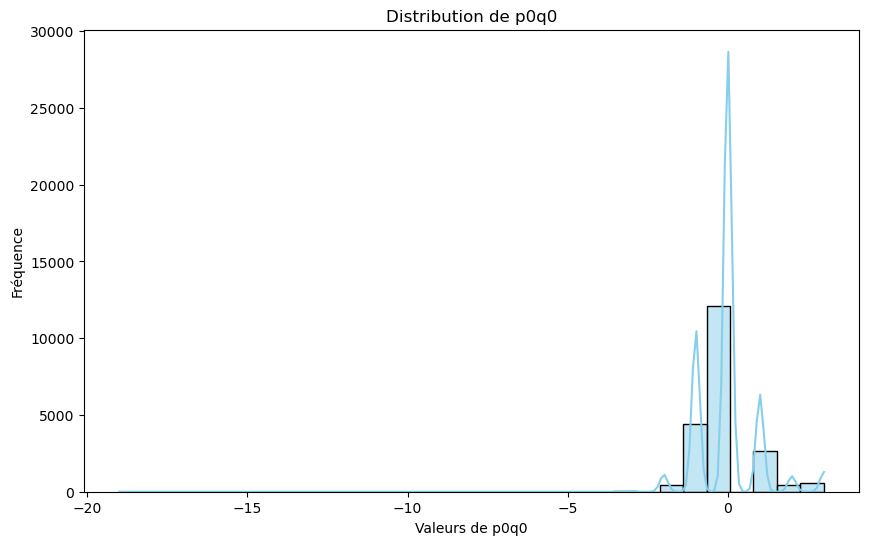

In [ ]:
# Tracer la distribution
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(predictions_df['p0q0'], kde=True, bins=30, color='skyblue')

# Ajouter des titres et des labels
plt.title('Distribution de p0q0')
plt.xlabel('Valeurs de p0q0')
plt.ylabel('Fréquence')

# Afficher le graphique
plt.show()


In [ ]:
import csv
#Prendre les arrondis de chaque valeur
predictions_df['p0q0'] = round(predictions_df["p0q0"])
predictions_df.to_csv('predictions_arrondi.csv',index=False)